# Crime Dataset
In this section we are going to explore data coming from https://data.world/ucr/crime-in-us-2016-offenses (login is required though).

It is related to all sorts of crimes committed in the United States, with information regarding violent crimes, homicides, robberies, crimes in University campuses and handguns related crimes.

We hope that information regarding crime will be helpful to estimate better our Human Development Index by state. (clearly, the higher the crime ratio, the lower the HDI we expect the country will be able to achieve.)

In [7]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import re

In [8]:
# We start by loading the list of states in the USA
# This will come useful when looking for missing values
states_json = pd.read_json('Data/states.json')
states = []

for row in states_json['data']:
    states.append(row['State'])
    
states_df = pd.DataFrame({"State": states})
states_df.head()

,State
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


### Crime in US by state
We start our analysis by loading the dataset Crimes in the US by state
It contains information regarding 
- Murder and  nonnegligent  manslaughter
- Rape (revised definition)
- Rape (legacy definition)
- Robbery
- Aggravated assault
- Property crime
- Burglary
- Larceny- theft
- Motor  vehicle  theft


In [9]:
# Read from excel
crimes_per_state_df = pd.read_excel("Data/crime/Table_3_Crime_in_the_United_States_by_State_2016.xls", skiprows=3)

# get only the columns we are interested in
new_df = crimes_per_state_df[(crimes_per_state_df.State.notnull()) | (crimes_per_state_df.Area == 'State Total') | (crimes_per_state_df['Unnamed: 2'] == 'Rate per 100,000 inhabitants')].reset_index()


We can see that data is put in a pretty confusional way: every country lies on 3 separated lines, the first line has the name only, the second line has the statistics for the entire country, the third has data scaled per 100k inhabitants.

We therefore need to convert the data into a uniform line.

We start by merging together the first 2 lines for every country.
We keep only the country name for the first line, and for everything else we keep the data in the second line.

In [10]:
# We split the dataset in three different dataframes, that we are going to join together.

# first dataframe is the one with states
states_row_df = crimes_per_state_df[crimes_per_state_df['State'].notnull()].reset_index()

# second dataframe is the one with data per the totality of the state
states_total_df = crimes_per_state_df[crimes_per_state_df['Area'] == 'State Total'].reset_index()

# third dataframe is the one with all other lines
states_per_100k_df = crimes_per_state_df[crimes_per_state_df['Unnamed: 2'] == 'Rate per 100,000 inhabitants'].reset_index()

crimes_per_state_merged_df = states_row_df[['State']].merge(states_total_df[['Population']], left_index=True, right_index=True)
crimes_per_state_merged_df = crimes_per_state_merged_df.merge(states_per_100k_df[['Violent\ncrime1', 'Murder and \nnonnegligent \nmanslaughter', 'Rape\n(revised\ndefinition)2 ', 'Robbery', 'Aggravated \nassault', 'Property \ncrime', 'Burglary', 'Larceny-\ntheft', 'Motor \nvehicle \ntheft']], left_index=True, right_index=True)
crimes_per_state_merged_df.head()


,State,Population,Violent\ncrime1,Murder and \nnonnegligent \nmanslaughter,Rape\n(revised\ndefinition)2,Robbery,Aggravated \nassault,Property \ncrime,Burglary,Larceny-\ntheft,Motor \nvehicle \ntheft
0,ALABAMA,4863300,532.3,8.4,39.4,96.4,388.2,2947.8,700.5,2006.3,241.1
1,ALASKA,741894,804.2,7,141.9,114.6,540.6,3353,546.3,2394.7,412.1
2,ARIZONA,6931071,470.1,5.5,47.5,101.8,315.4,2978.4,544.4,2168.1,265.8
3,ARKANSAS,2988248,550.9,7.2,71.7,70.9,401,3268.6,795.5,2233.6,239.4
4,CALIFORNIA,39250017,445.3,4.9,34.9,139.6,265.9,2553,479.8,1623.0,450.3


### Data Analysis
First, we need to see if we have missing values

In [11]:
print("The shape of our dataset is {}".format(crimes_per_state_merged_df.shape))

The shape of our dataset is (50, 11)


Actually, what it seems is that we have even more columns than what we expected! We can try to merge the states with the states_df computed in the first point (using the lowercase version of it).

In [12]:
# we compute the lowercase version of the state name in the dataframe state_df
states_df['lowercase'] = states_df['State'].apply(lambda x: x.lower())

# we compute the lowercase version of the state name in the dataframe crimes_per_state_merged_df (but first we need to remove numbers))
crimes_per_state_merged_df['lowercase'] = crimes_per_state_merged_df['State'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]).lower())

merged_states = states_df.merge(crimes_per_state_merged_df[['State', 'lowercase']], left_on='lowercase', right_on='lowercase', how='right')

We can now spot which one is the wrong value:

In [13]:
merged_states[pd.isnull(merged_states).any(axis=1)]

,State_x,lowercase,State_y
49,NaN,puerto rico,PUERTO RICO7


We can see that the table coming from the crime dataset of the United States contains information regarding Puerto Rico (which is part of the United States, but in a broader way).
Therefore we can easily discard it and move on with our analysis.

In [14]:
df = crimes_per_state_merged_df.drop(crimes_per_state_merged_df[crimes_per_state_merged_df.State == 'PUERTO RICO7'].index, axis=0).reset_index()
df.head()

,index,State,Population,Violent\ncrime1,Murder and \nnonnegligent \nmanslaughter,Rape\n(revised\ndefinition)2,Robbery,Aggravated \nassault,Property \ncrime,Burglary,Larceny-\ntheft,Motor \nvehicle \ntheft,lowercase
0,0,ALABAMA,4863300,532.3,8.4,39.4,96.4,388.2,2947.8,700.5,2006.3,241.1,alabama
1,1,ALASKA,741894,804.2,7,141.9,114.6,540.6,3353,546.3,2394.7,412.1,alaska
2,2,ARIZONA,6931071,470.1,5.5,47.5,101.8,315.4,2978.4,544.4,2168.1,265.8,arizona
3,3,ARKANSAS,2988248,550.9,7.2,71.7,70.9,401,3268.6,795.5,2233.6,239.4,arkansas
4,4,CALIFORNIA,39250017,445.3,4.9,34.9,139.6,265.9,2553,479.8,1623.0,450.3,california


## Data formatting
We should convert all data into a more reasonable format: for instance, states should be named with the name in the dataframe states_df, and all numbers should be of type float.
Moreover, a more reasonable set of names on the columns should be selected!

In [15]:
df.dtypes

index                                         int64
State                                        object
Population                                   object
Violent\ncrime1                              object
Murder and \nnonnegligent \nmanslaughter     object
Rape\n(revised\ndefinition)2                float64
Robbery                                     float64
Aggravated \nassault                         object
Property \ncrime                             object
Burglary                                     object
Larceny-\ntheft                             float64
Motor \nvehicle \ntheft                     float64
lowercase                                    object
dtype: object

First, we proceed in renaming the columns: we even substitute the State attribute with the correct one found in state_df

In [16]:
df.columns = ['index', 'State', 'Population', 'Violent_Crime', 'Murder_and_Manslaughter', 'Rape', 'Robbery', 'Aggravated_Assoult', 'Property_crime', 'Burglary', 'Theft', 'Motor_Vehicle_theft', 'lowercase']

In [17]:
# we use as state column the one used in the state dataframe, so that the names are all equally formatted (we have to merge together different DataFrames at the end of each analysis)
df['State'] = states_df.merge(df, left_on='lowercase', right_on='lowercase')['State_x']

In [18]:
df.head()

,index,State,Population,Violent_Crime,Murder_and_Manslaughter,Rape,Robbery,Aggravated_Assoult,Property_crime,Burglary,Theft,Motor_Vehicle_theft,lowercase
0,0,Alabama,4863300,532.3,8.4,39.4,96.4,388.2,2947.8,700.5,2006.3,241.1,alabama
1,1,Alaska,741894,804.2,7,141.9,114.6,540.6,3353,546.3,2394.7,412.1,alaska
2,2,Arizona,6931071,470.1,5.5,47.5,101.8,315.4,2978.4,544.4,2168.1,265.8,arizona
3,3,Arkansas,2988248,550.9,7.2,71.7,70.9,401,3268.6,795.5,2233.6,239.4,arkansas
4,4,California,39250017,445.3,4.9,34.9,139.6,265.9,2553,479.8,1623.0,450.3,california


As we can see, only a few columns have numerical features. Therefore we have to convert them.


In [19]:
df.dtypes

index                        int64
State                       object
Population                  object
Violent_Crime               object
Murder_and_Manslaughter     object
Rape                       float64
Robbery                    float64
Aggravated_Assoult          object
Property_crime              object
Burglary                    object
Theft                      float64
Motor_Vehicle_theft        float64
lowercase                   object
dtype: object

In [20]:
# Convert string features to numbers (int or float)
df.Population = df['Population'].apply(lambda x: int(x))
df.Violent_Crime = df.Violent_Crime.apply(lambda x: float(x))
df.Murder_and_Manslaughter = df.Murder_and_Manslaughter.apply(lambda x: float(x))
df.Aggravated_Assoult = df.Aggravated_Assoult.apply(lambda x: float(x))
df.Property_crime = df.Property_crime.apply(lambda x: float(x))
df.Burglary = df.Burglary.apply(lambda x: float(x))

# Drop lowercase column, used only to merge with state dataframe
df = df.drop(['lowercase'], axis=1)

## Null values
We can start now looking for missing data

In [21]:
# We look for any NULL value in df
df[pd.isnull(df).any(axis=1)]

,index,State,Population,Violent_Crime,Murder_and_Manslaughter,Rape,Robbery,Aggravated_Assoult,Property_crime,Burglary,Theft,Motor_Vehicle_theft


There aren't any luckily! :)

## Save Pickke
We save the df into a pickle file, so that it can be used later for further analysis.

In [22]:
df.to_pickle("Pickles/crime.pickle")

We therefore can now plot the resulting distributions of the various columns, and see if thery are somehow related to each other.

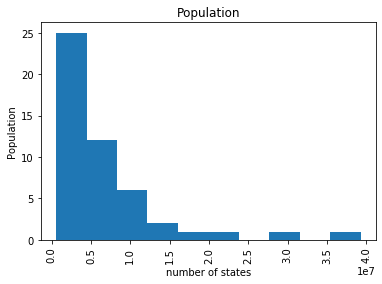

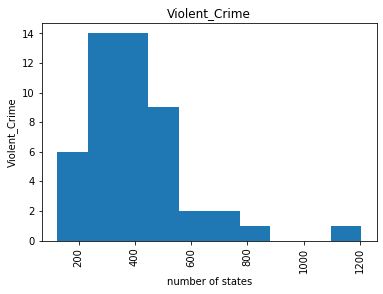

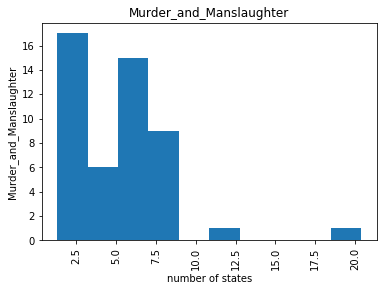

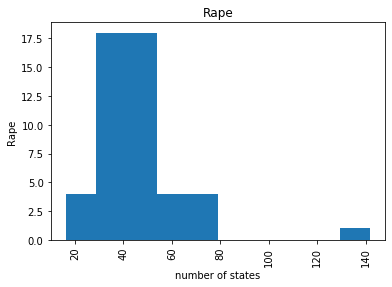

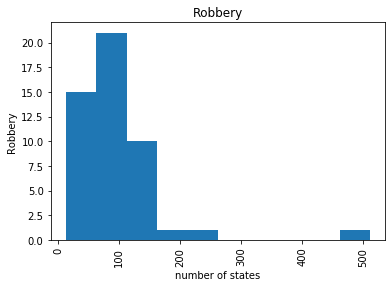

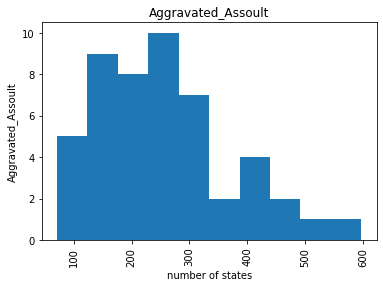

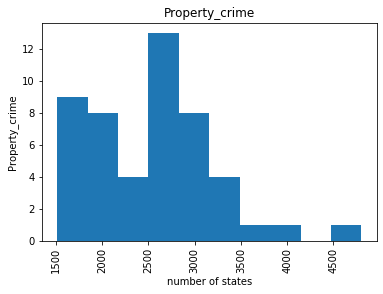

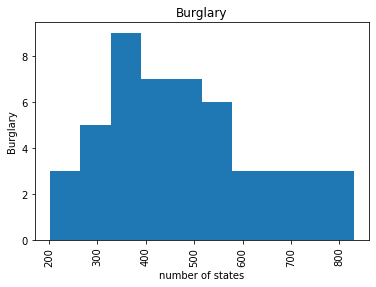

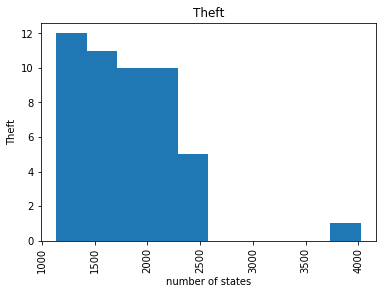

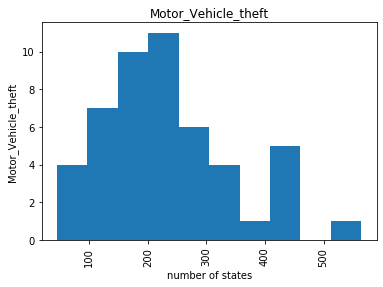

In [23]:
for i, col in enumerate(df.columns):
    if col != 'index' and df[col].dtype != 'object':
        plt.figure(i)
        plt.xticks(rotation=90)
        plt.xlabel("number of states")
        plt.ylabel(col)
        plt.title(col)
        plt.hist(df[col])

We can see that in almost all charts there is one (little) outlier. Let's see if we can spot it.

In [24]:
# We print the country which has a maximum in every numerical column
for col in df.columns:
    if col != 'index' and df[col].dtype != 'object':
        print("The max value for feature {} is of state {}".format(col, df[df[col] == df[col].max()].State))

The max value for feature Population is of state 4    California
Name: State, dtype: object
The max value for feature Violent_Crime is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Murder_and_Manslaughter is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Rape is of state 1    Alaska
Name: State, dtype: object
The max value for feature Robbery is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Aggravated_Assoult is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Property_crime is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Burglary is of state 31    New Mexico
Name: State, dtype: object
The max value for feature Theft is of state 8    District of Columbia
Name: State, dtype: object
The max value for feature Motor_Vehicle_theft is of state 31    New Mexico
Name: State, dtype: object


### Analysis
We can see that the district of Columbia has unexpected high values. This may be related to the fact that it is the only American State which is actually a city, where usually the criminality rates are higher than in rural areas.

To conclude, we would like to see if there is a positive correlation among every kind of crimes:

In [25]:
numerical_features = []
for col in df.columns:
    # we skip the features which are non numerical, and the index column
    if (df[col].dtype == int or df[col].dtype == float) and col != 'index':
        numerical_features.append(col)
df[numerical_features].corr()

,Population,Violent_Crime,Murder_and_Manslaughter,Rape,Robbery,Aggravated_Assoult,Property_crime,Burglary,Theft,Motor_Vehicle_theft
Population,1.000000,0.188670,0.054858,0.076123,0.210687,0.151858,0.112468,-0.109866,0.119661,0.297212
Violent_Crime,0.188670,1.000000,0.825974,0.586599,0.816001,0.947832,0.725658,0.387803,0.724927,0.577094
Murder_and_Manslaughter,0.054858,0.825974,1.000000,0.286241,0.838013,0.704132,0.651725,0.396814,0.678062,0.333515
Rape,0.076123,0.586599,0.286241,1.000000,0.235125,0.607124,0.502249,0.249837,0.476199,0.535880
Robbery,0.210687,0.816001,0.838013,0.235125,1.000000,0.600328,0.574303,0.115580,0.644091,0.422321
Aggravated_Assoult,0.151858,0.947832,0.704132,0.607124,0.600328,1.000000,0.685102,0.486831,0.644024,0.549259
Property_crime,0.112468,0.725658,0.651725,0.502249,0.574303,0.685102,1.000000,0.662954,0.961845,0.774754
Burglary,-0.109866,0.387803,0.396814,0.249837,0.115580,0.486831,0.662954,1.000000,0.464405,0.472439
Theft,0.119661,0.724927,0.678062,0.476199,0.644091,0.644024,0.961845,0.464405,1.000000,0.666001
Motor_Vehicle_theft,0.297212,0.577094,0.333515,0.535880,0.422321,0.549259,0.774754,0.472439,0.666001,1.000000


Although it is not true for all columns (Rape and Burglary), usually we can see that the correlation ratios are quite well correlated. This means that id one country is usually high in any sort of crime, it is very likely that it is high in all other statistics for crime related features.

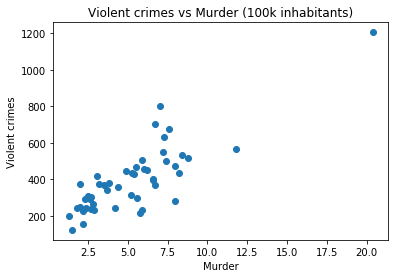

In [26]:
# just to make some examples
plt.figure(1)
plt.title("Violent crimes vs Murder (100k inhabitants)")
plt.xlabel("Murder")
plt.ylabel("Violent crimes")
plt.scatter(df['Murder_and_Manslaughter'], df['Violent_Crime'])

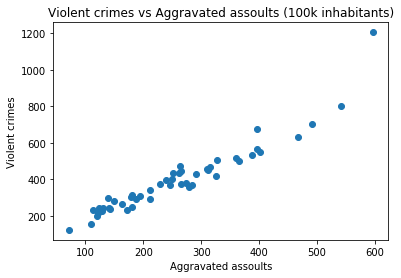

In [27]:
plt.figure(1)
plt.title("Violent crimes vs Aggravated assoults (100k inhabitants)")
plt.xlabel("Aggravated assoults")
plt.ylabel("Violent crimes")
plt.scatter(df['Aggravated_Assoult'], df['Violent_Crime'])

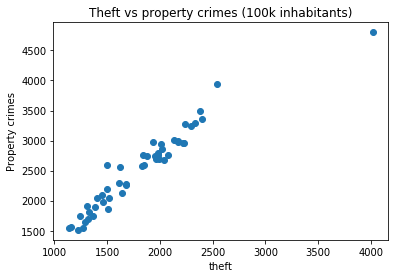

In [28]:
plt.figure(1)
plt.title("Theft vs property crimes (100k inhabitants)")
plt.xlabel("theft")
plt.ylabel("Property crimes")
plt.scatter(df['Theft'], df['Property_crime'])

They all show clear linear relationship among the two selected features.